In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob
import pickle
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

## Camera calibration

In [2]:
# camera calibration

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

imgpoints = []
objpoints = []

images = glob.glob('./camera_cal/calibration*.jpg')
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (7,6), corners2,ret)


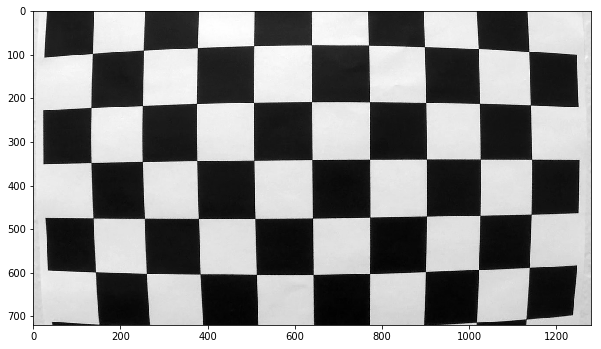

In [3]:
img = cv2.imread('camera_cal/calibration1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#print(img)
plt.imshow(img, cmap='gray')

(1280, 720)


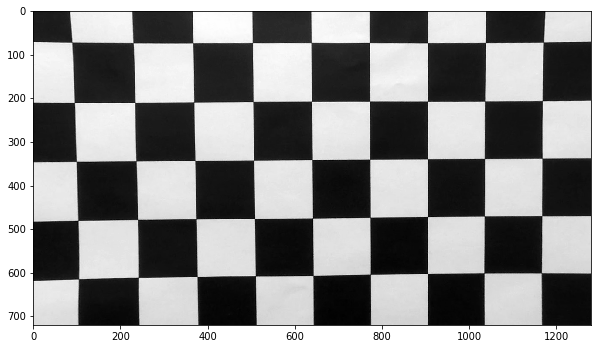

In [4]:
img_size = (img.shape[1], img.shape[0])
print(img_size)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )
plt.imshow(dst, cmap='gray') # Undistorted Image

### Implement image undistortion in function

#### Function `imgUndistort(img, mtx, dist)`

In [5]:
def imgUndistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

#### Test and plot

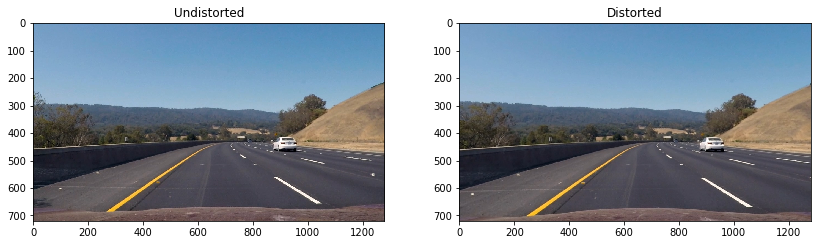

In [6]:
test_img = cv2.imread('test_images/test3.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

test_img_undist = imgUndistort(test_img, mtx, dist)

plt.rcParams['figure.figsize'] = (14, 8)
plt.figure()
plt.subplot(221)
plt.title("Undistorted")
plt.imshow(test_img)
plt.subplot(222)
plt.title("Distorted")
plt.imshow(test_img_undist)
plt.show()

## Perspective transformation

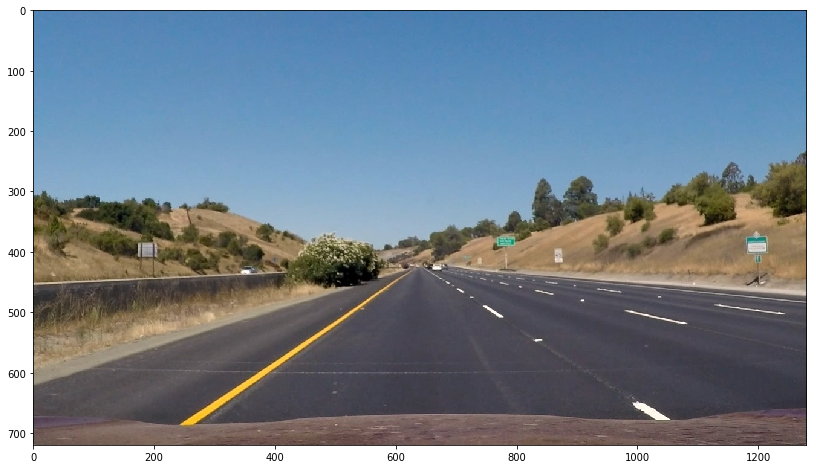

In [7]:
img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

### Undistorted test image

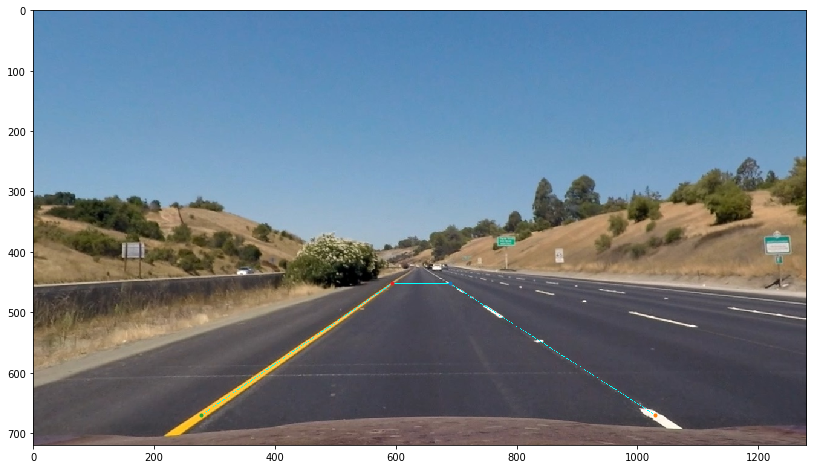

In [8]:
dist_pickle = pickle.load( open( "calibration.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
dst = imgUndistort(img, mtx, dist)
pts = np.array([[689, 452],[1029, 670],[278, 670],[593, 452]], np.int32)
pts = pts.reshape((-1,1,2))
cv2.polylines(dst,[pts],True,(0,255,255))
plt.plot(689, 452,'.')
plt.plot(1029, 670,'.')
plt.plot(278, 670,'.')
plt.plot(593, 452,'.')
plt.imshow(dst)

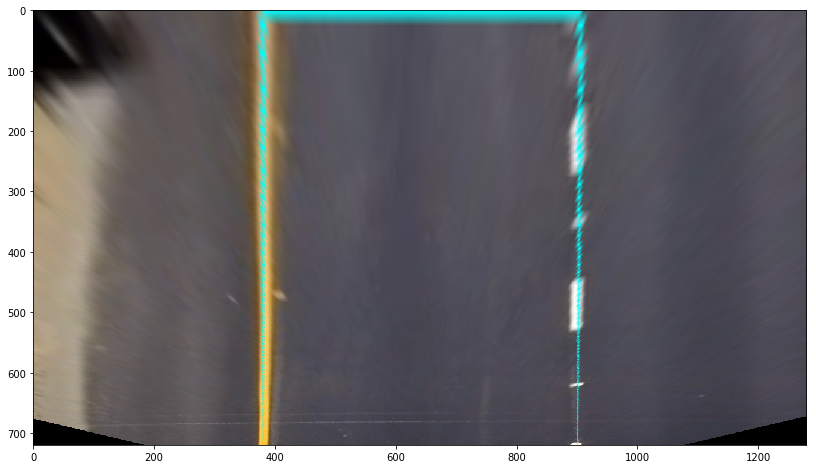

In [9]:
h,w = dst.shape[:2]
src_p = np.float32(
    [
        [688, 452],
        [1029, 670],
        [278, 670],
        [593, 452]
    ]
)

dst_p = np.float32(
    [
        [w-380, 0],
        [w-380, h],
        [380, h],
        [380, 0]
    ]
)

M = cv2.getPerspectiveTransform(src_p, dst_p)
Minv = cv2.getPerspectiveTransform(dst_p, src_p)

warped = cv2.warpPerspective(dst, M, (w,h), flags=cv2.INTER_LINEAR)
plt.imshow(warped)


### Implement perspective transformation in function

#### Function `getPerspectiveTransMatrix()` and `perspectiveTrans(img, M)`

In [10]:
def getPerspectiveTransMatrix():
    src_p = np.float32(
        [
            [688, 452],
            [1029, 670],
            [278, 670],
            [593, 452]
        ]
    )

    dst_p = np.float32(
        [
            [w-380, 0],
            [w-380, h],
            [380, h],
            [380, 0]
        ]
    )
    M = cv2.getPerspectiveTransform(src_p, dst_p)
    Minv = cv2.getPerspectiveTransform(dst_p, src_p)
    return M, Minv

def perspectiveTrans(img, M):
    h,w = img.shape[:2]
    return cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    

#### Test and plot

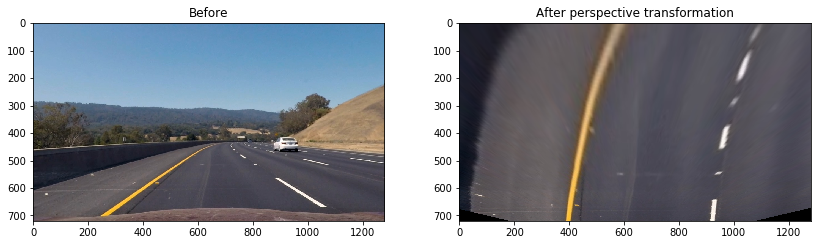

In [11]:
#test_img_undist
M, Minv = getPerspectiveTransMatrix()
test_img_pertrans = perspectiveTrans(test_img_undist, M)

plt.rcParams['figure.figsize'] = (14, 8)
plt.figure()
plt.subplot(221)
plt.title("Before")
plt.imshow(test_img_undist)
plt.subplot(222)
plt.title("After perspective transformation")
plt.imshow(test_img_pertrans)
plt.show()

## Color space and gradient thresholds
I'm going to try RGB, HSL and HSV to see which is better.

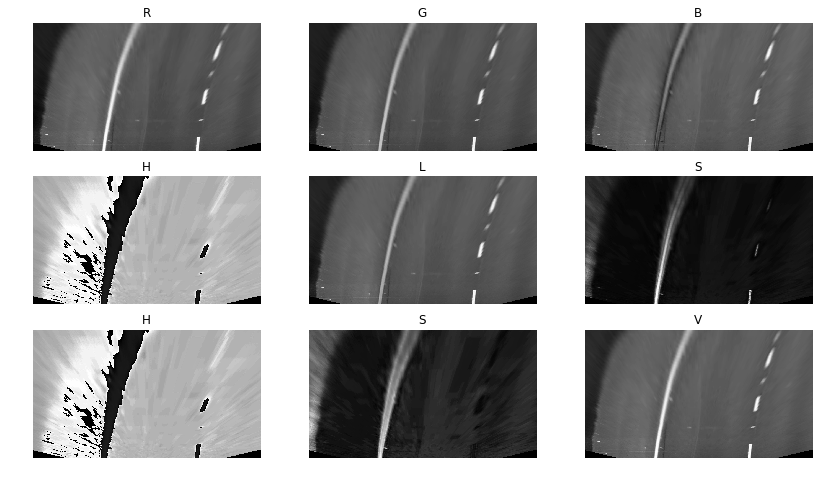

In [13]:
img = cv2.imread('test_images/test3.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
img = imgUndistort(test_img, mtx, dist)
M,Minv = getPerspectiveTransMatrix()
img = perspectiveTrans(img, M)


RGB_img = img
HLS_img = cv2.cvtColor(RGB_img, cv2.COLOR_RGB2HLS)
HSV_img = cv2.cvtColor(RGB_img, cv2.COLOR_RGB2HSV)
a = HLS_img[:,:,0]

plt.figure()
plt.subplot(331)
plt.title('R')
plt.axis('off')
plt.imshow(RGB_img[:,:,0], cmap='gray')
plt.subplot(332)
plt.title('G')
plt.axis('off')
plt.imshow(RGB_img[:,:,1], cmap='gray')
plt.subplot(333)
plt.title('B')
plt.axis('off')
plt.imshow(RGB_img[:,:,2], cmap='gray')

plt.subplot(334)
plt.title('H')
plt.axis('off')
plt.imshow(HLS_img[:,:,0], cmap='gray')
plt.subplot(335)
plt.title('L')
plt.axis('off')
plt.imshow(HLS_img[:,:,1], cmap='gray')
plt.subplot(336)
plt.title('S')
plt.axis('off')
plt.imshow(HLS_img[:,:,2], cmap='gray')

plt.subplot(337)
plt.title('H')
plt.axis('off')
plt.imshow(HSV_img[:,:,0], cmap='gray')
plt.subplot(338)
plt.title('S')
plt.axis('off')
plt.imshow(HSV_img[:,:,1], cmap='gray')
plt.subplot(339)
plt.title('V')
plt.axis('off')
plt.imshow(HSV_img[:,:,2], cmap='gray')

plt.show()



### Thresholds

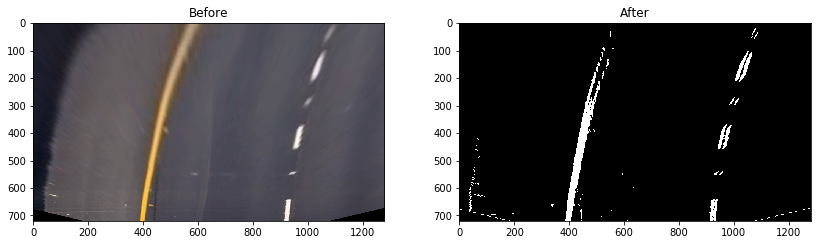

In [14]:
def binary_gray(img, thresh = (100, 255)):
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    HLS_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    gray = cv2.cvtColor(HLS_img, cv2.COLOR_RGB2GRAY)
    gray_bin = np.zeros_like(gray)
    gray_bin[(gray > thresh[0]) & (gray <= thresh[1])] = 1
    return gray_bin

def pipeline(img, s_thresh=(140, 255), sx_thresh=(18, 255), l_thresh=(60,255)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    #color_binary = np.dstack(( sxbinary, sxbinary, s_binary)) * 255
    color_binary = np.zeros_like(sxbinary)
    color_binary[((l_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
    binary = 255*np.dstack((color_binary,color_binary,color_binary)).astype('uint8')
    return color_binary

import matplotlib.image as mpimg
img = mpimg.imread('test_images/test2.jpg')
thres_img = pipeline(RGB_img)

plt.figure()
plt.subplot(221)
plt.title("Before")
plt.imshow(RGB_img, cmap='gray')
plt.subplot(222)
plt.title("After")
plt.imshow(thres_img, cmap='gray')
plt.show()

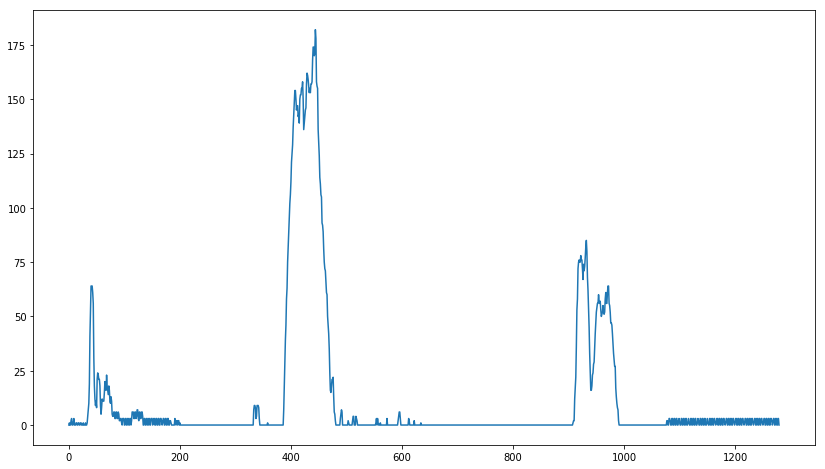

In [15]:
histogram = np.sum(thres_img[thres_img.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [16]:
def findLaneLine(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return leftx, lefty, left_fit, rightx, righty, right_fit

In [20]:
leftx, lefty, left_fit, rightx, righty, right_fit = findLaneLine(thres_img)

binary_warped = thres_img
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
'''
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
'''


"\nout_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]\nout_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]\nplt.imshow(out_img)\nplt.plot(left_fitx, ploty, color='yellow')\nplt.plot(right_fitx, ploty, color='yellow')\nplt.xlim(0, 1280)\nplt.ylim(720, 0)\n"

In [21]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

2796.94389658 2197.97902105


In [22]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
#print((ploty*ym_per_pix).shape, (leftx*xm_per_pix).shape)
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')


905.964702287 m 716.294703074 m


### Implement lane line visualization

In [23]:
def visLaneLine(undist, thres_img, Minv):
    leftx, lefty, left_fit, rightx, righty, right_fit = findLaneLine(thres_img)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(thres_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    #print((ploty*ym_per_pix).shape, (leftx*xm_per_pix).shape)
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    
    # Now finding road center
    h = undist.shape[0]
    w = undist.shape[1]
    l_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
    r_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
    lane_center = (r_fit_x_int + l_fit_x_int) /2
    
    bias = (w/2 - lane_center) * xm_per_pix
    if bias > 0:
        hud_string_center = "Vehicle is %.2f (m) right of center" % np.abs(bias)
    else:
        hud_string_center = "Vehicle is %.2f (m) left of center" % np.abs(bias)
    
    radius = np.mean([left_curverad, right_curverad])
    hud_string_radius = "Radius of curvature =  %.2f (m)" % radius
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,hud_string_center,(10,40), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,hud_string_radius,(10,80), font, 1,(255,255,255),2,cv2.LINE_AA)
    plt.imshow(result)
    return result

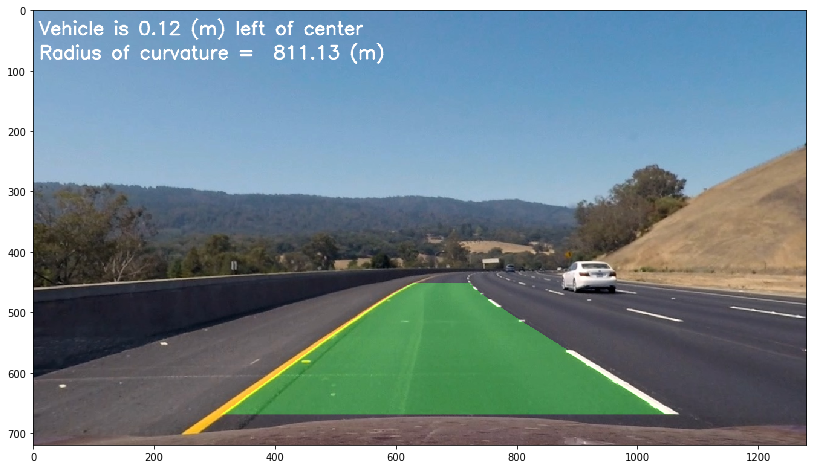

In [24]:
M, Minv = getPerspectiveTransMatrix()
found_result = visLaneLine(test_img_undist, thres_img, Minv)
#plt.imshow(result)

## Complete pipline

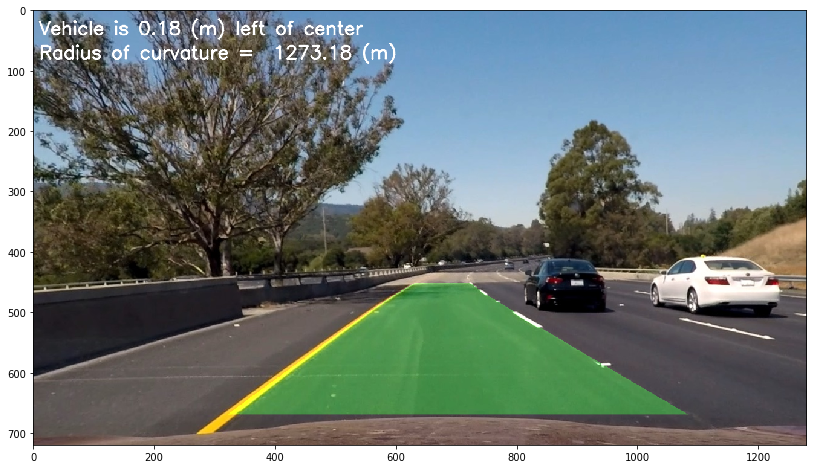

In [55]:
test_img = cv2.imread('test_images/test6.jpg')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

test_img_undist = imgUndistort(test_img, mtx, dist)

M, Minv = getPerspectiveTransMatrix()
test_img_pertrans = perspectiveTrans(test_img_undist, M)

thres_img = pipeline(test_img_pertrans)

found_result = visLaneLine(test_img_undist, thres_img, Minv)

plt.imshow(found_result)

### All-in-one function

In [44]:
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
M, Minv = getPerspectiveTransMatrix()


def drawLaneLine(img):
    test_img_undist = imgUndistort(img, mtx, dist)
    test_img_pertrans = perspectiveTrans(test_img_undist, M)

    thres_img = pipeline(test_img_pertrans)

    vis_img = visLaneLine(test_img_undist, thres_img, Minv)
    
    return vis_img


In [45]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is not None:
            images.append(img)
    return images

sample_images = np.array(load_images_from_folder('test_images'))
straight_lines_imgs = sample_images[0:2]
test_imgs = sample_images[2:]

(2, 720, 1280, 3)
(6, 720, 1280, 3)


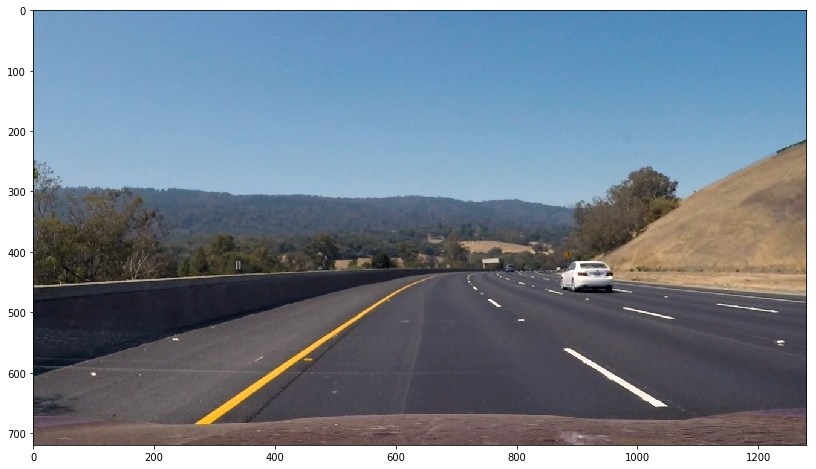

In [46]:
plt.imshow(straight_lines_imgs[0])
print(straight_lines_imgs.shape)
print(test_imgs.shape)

In [47]:
cap = cv2.VideoCapture('challenge_video.mp4')
frames = []
while(True):
    ret, frame = cap.read()
    if ret == 0:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)
    
cap.release()

In [48]:
frames = np.array(frames)
print(frames.shape)

(469, 720, 1280, 3)


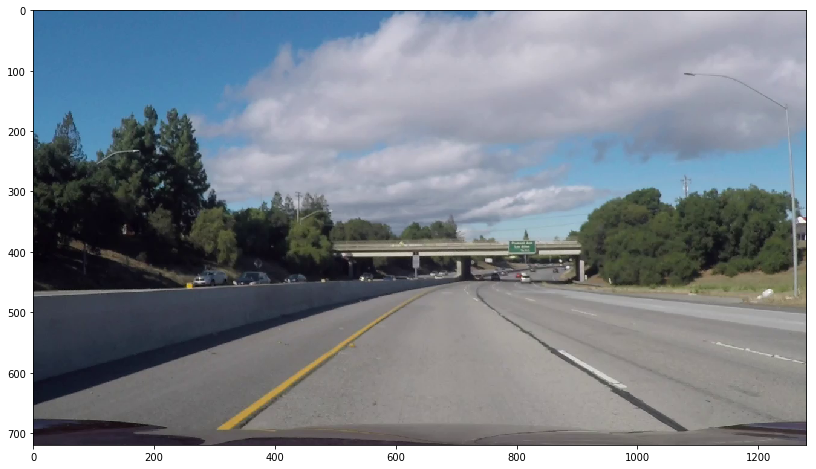

In [49]:
plt.imshow(frames[0])

In [50]:
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
M, Minv = getPerspectiveTransMatrix()

from tqdm import tqdm 
processed_frames = []
#for frame in tqdm(frames):
    #processed_frames.append(drawLaneLine(frame, mtx, dist, M, Minv))

[MoviePy] >>>> Building video ./processed_project_video.mp4
[MoviePy] Writing video ./processed_project_video.mp4


100%|█████████▉| 1260/1261 [01:54<00:00, 11.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./processed_project_video.mp4 

CPU times: user 2min 45s, sys: 6.4 s, total: 2min 51s
Wall time: 1min 54s


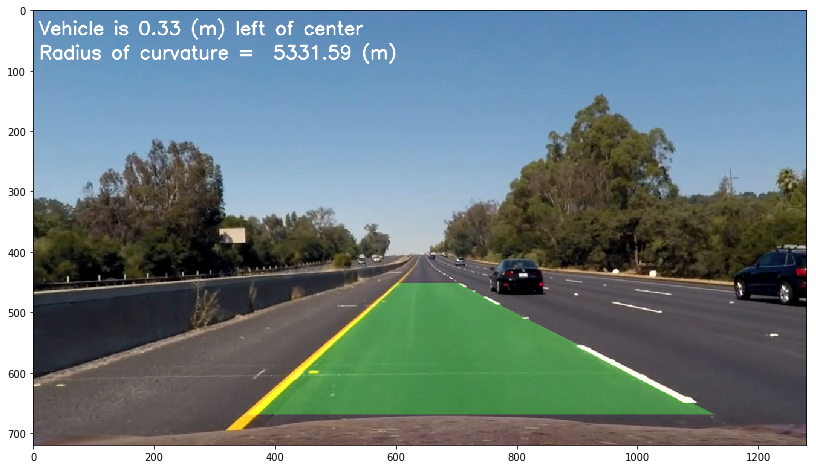

In [52]:
'''
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('processed_roject.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 30, (1280, 720))
for frame in processed_frames:
    out.write(frame)
out.release()
'''

from moviepy.editor import VideoFileClip
out_dir='./'
output = out_dir+'processed_project_video.mp4'
clip = VideoFileClip("project_video.mp4")
out_clip = clip.fl_image(drawLaneLine) 
%time out_clip.write_videofile(output, audio=False)

In [ ]:
plt.imshow(processed_frames[10])